In [2]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.random import random_circuit
import random
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Kraus, SuperOp
import pickle
import numpy as np
from scipy.linalg import sqrtm

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [24]:
#method for randomly generating a POVM set of size d on some n-dimensional basis space (should be n = 2**q where q is number of qubits) 
def generate_POVMs(n, d=-1, seed=10):
    np.random.seed(seed)
    #if d is negative defaults to an informationally complete set (n^2 many)
    if d<1:
        d = n**2
    #first, generate d linearly independent non-negative operators
    vectors = []
    for i in range(d):
        real = np.randn(n)
        imag = np.randn(n)
        vector = real + imag * 1j
        vector /= np.linalg.norm(vector)
        vectors.append(vector)
    #sum up all of the vectors
    G = np.zeros((n, n), dtype=np.complex128)
    for vector in vectors:
        G += np.outer(vector, np.conj(vector))
    #take square root of matrix, take inverse of matrix
    Ginvhalf = np.linalg.inv(sqrtm(G))
    #compute POVMs
    POVMs = []
    for vector in vectors:
        E = Ginvhalf @ vector
        POVMs.append(E) #stores only one half of a POVM element -- to save on space!
    return np.array(POVMs)

In [4]:
### feed me a noiseless quantum circuit, I will save all the data from that.

"""
circ: a QuantumCircuit without measurement at the end
name: name you want to save it as
povm: whether to use POVM or standard measurements
n_meas: how many POVM measurements is the set?
shots: number of shots
"""
def get_noiseless_circuit_data(circ, name, povm=False, n_meas=-1, seed=15, shots=10000):
    n = circ.num_qubits
    
    #find statevector
    psi = qi.Statevector.from_instruction(circ).data #assuming a pure state
    #find density matrix
    rho = qi.DensityMatrix.from_instruction(circ).data
    
    if povm:
        if n_meas < 0:
            n_meas = 2**(2*n)
        POVM_set = generate_POVMs(2**n, n_meas, seed)
        probabilities = np.array([ (np.abs(np.dot(np.conj(POVM), psi))**2) for POVM in POVM_set])
        with open(f"data/{name}_POVM", "wb") as f:
            pickle.dump(POVM_set, f)
        print(f"Saved POVM set for {name}: {n} qubits, {n_meas} measurement outcomes")
    else:
        print("using standard measurement basis")
        #standard measurement
        probabilities = np.array([ np.abs(psi[i])**2 for i in range(len(psi))])
    with open(f"data/{name}_statistics", "w") as f:
        for i in range(len(probabilities)):
            f.write(f"{i} {probabilities[i]}\n")
    with open(f"data/{name}_density","wb") as file:
        pickle.dump(rho, file)
    print(f"Saved statistics and density matrix for {name}")

In [4]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0,1)
get_noiseless_circuit_data(circ, "GHZ_2", povm=True, n_meas=10)

n = 5
depth = 10
name = f"random_{n}_1000"
randcirc = random_circuit(n,depth,measure=False, seed=1517)
get_noiseless_circuit_data(randcirc, name, povm=True, n_meas = 1000)

Saved POVM set for GHZ_2: 2 qubits, 10 measurement outcomes
Saved statistics and density matrix for GHZ_2
Saved POVM set for random_5_1000: 5 qubits, 1000 measurement outcomes
Saved statistics and density matrix for random_5_1000


In [19]:
n=3
circ = QuantumCircuit(n)
circ.h(0)
circ.cx(0,1)
circ.cx(1,2)
get_noiseless_circuit_data(circ, "GHZ_3", povm=True, n_meas=2**(n)*2,seed=16)

Saved POVM set for GHZ_3: 3 qubits, 16 measurement outcomes
Saved statistics and density matrix for GHZ_3


In [23]:
circ = QuantumCircuit(5)
circ.h(0)
circ.cx(0,1)
circ.cx(1,2)
circ.cx(2,3)
circ.cx(3,4)
get_noiseless_circuit_data(circ, "GHZ_5", povm=True)

Saved POVM set for GHZ_5: 5 qubits, 1024 measurement outcomes
Saved statistics and density matrix for GHZ_5


In [173]:
def get_noisy_circuit_data(circ, noise_model, name, povm=False, n_meas=-1, seed=15, shots=10000):
        #Not Implemented Yet
        return

        #for noisy measurements
        # circ.measure(range(n),range(n))
        # simulator = Aer.get_backend('aer_simulator')
        # tcirc = transpile(circ, simulator)
        # result = simulator.run(tcirc, shots=shots).result()
        # counts = result.get_counts()
        # #turn counts into estimated probabilities
        # probabilities = np.zeros(2**n)
        # for count in counts:
        #     idx = int(count,2)
        #     probabilities[idx] = counts[count]/shots

In [18]:
def get_two_circuit_data(circ1, circ2, name, povm=False, weight=0.5, n_meas=-1, seed=15, shots=10000):
    if weight <= 0 or weight >= 1:
        print("needs to have nontrivial weight on both circuits!")
        return
    n = circ1.num_qubits
    rho1 = qi.DensityMatrix.from_instruction(circ1).data
    rho2 = qi.DensityMatrix.from_instruction(circ2).data
    mixed = weight*rho1 + (1-weight)*rho2
    if povm:
        if n_meas < 0:
            n_meas = 2**(2*n)
        POVM_set = generate_POVMs(2**n, n_meas, seed)
        probabilities = np.array([ np.trace(np.outer(POVM, np.conj(POVM)) @ mixed).real for POVM in POVM_set])
        with open(f"data/{name}_POVM", "wb") as f:
            pickle.dump(POVM_set, f)
        print(f"Saved POVM set for {name}: {n} qubits, {n_meas} measurement outcomes")
    else:
        print("using standard measurement basis")
        #standard measurement
        probabilities = np.array([ np.abs(mixed[i][i])**2 for i in range(2**n)])
    with open(f"data/{name}_statistics", "w") as f:
        for i in range(len(probabilities)):
            f.write(f"{i} {probabilities[i]}\n")
    with open(f"data/{name}_density","wb") as file:
        pickle.dump(mixed, file)
    print(f"Saved statistics and density matrix for {name}")

In [21]:
circ1 = QuantumCircuit(2)
circ1.h(0)
circ1.cx(0,1)
circ2 = QuantumCircuit(2)
get_two_circuit_data(circ1, circ2, "mixed2", povm=True, weight=0.25, n_meas=16)

Saved POVM set for mixed2: 2 qubits, 16 measurement outcomes
Saved statistics and density matrix for mixed2


In [12]:
#random circuit
n = 3
depth = 10
name = f"random_{n}"

circ = random_circuit(n,depth,measure=True, seed=1515)
simulator = Aer.get_backend('aer_simulator')
tcirc = transpile(circ, simulator)
result = simulator.run(tcirc, shots=10000).result()
counts = result.get_counts()
print(counts)

# with open(f"data/{name}_counts", "w") as f:
#     for count in counts:
#         f.write(f"{int(count,2)} {counts[count]/10000}")
#         f.write("\n")
# print(f"saved {name} counts")
# circ = random_circuit(n,depth,measure=False, seed=1515)
#rho = qi.DensityMatrix.from_instruction(circ)
# with open(f"data/{name}_density","wb") as file:
#         pickle.dump(rho, file)
# print(f"saved {name} density matrix")
plot_histogram(counts, figsize = (14,10), filename='histogram.png')

{'101': 541, '111': 1763, '011': 2275, '000': 454, '010': 1610, '001': 836, '110': 1352, '100': 1169}


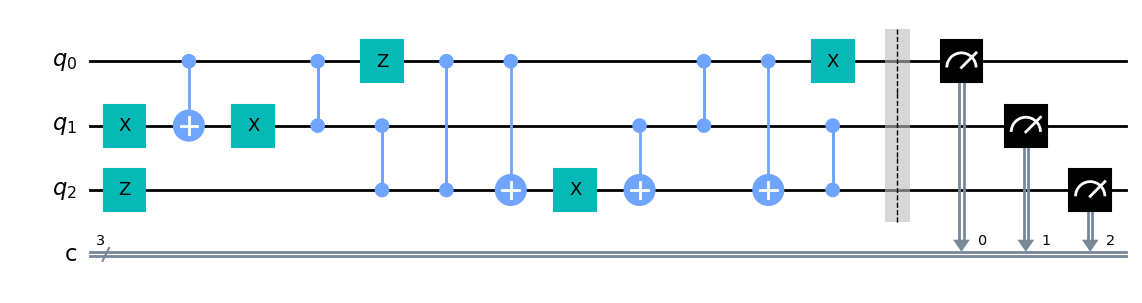

In [17]:
n = 3
depth = 15
qc = QuantumCircuit(n,n)
for i in range(depth):
    x = random.sample(range(n),2)
    gate = random.sample(range(5),1)[0]
    if gate==0:
        qc.x(x[0])
    elif gate==1:
        qc.cz(x[0],x[1])
    elif gate==2:
        qc.z(x[0])
    elif gate==3:
        qc.cx(x[0],x[1])
    elif gate==4:
        qc.h(x[0])
qc.barrier()
qc.measure(range(n),range(n))
qc.draw('mpl', filename='circuit')

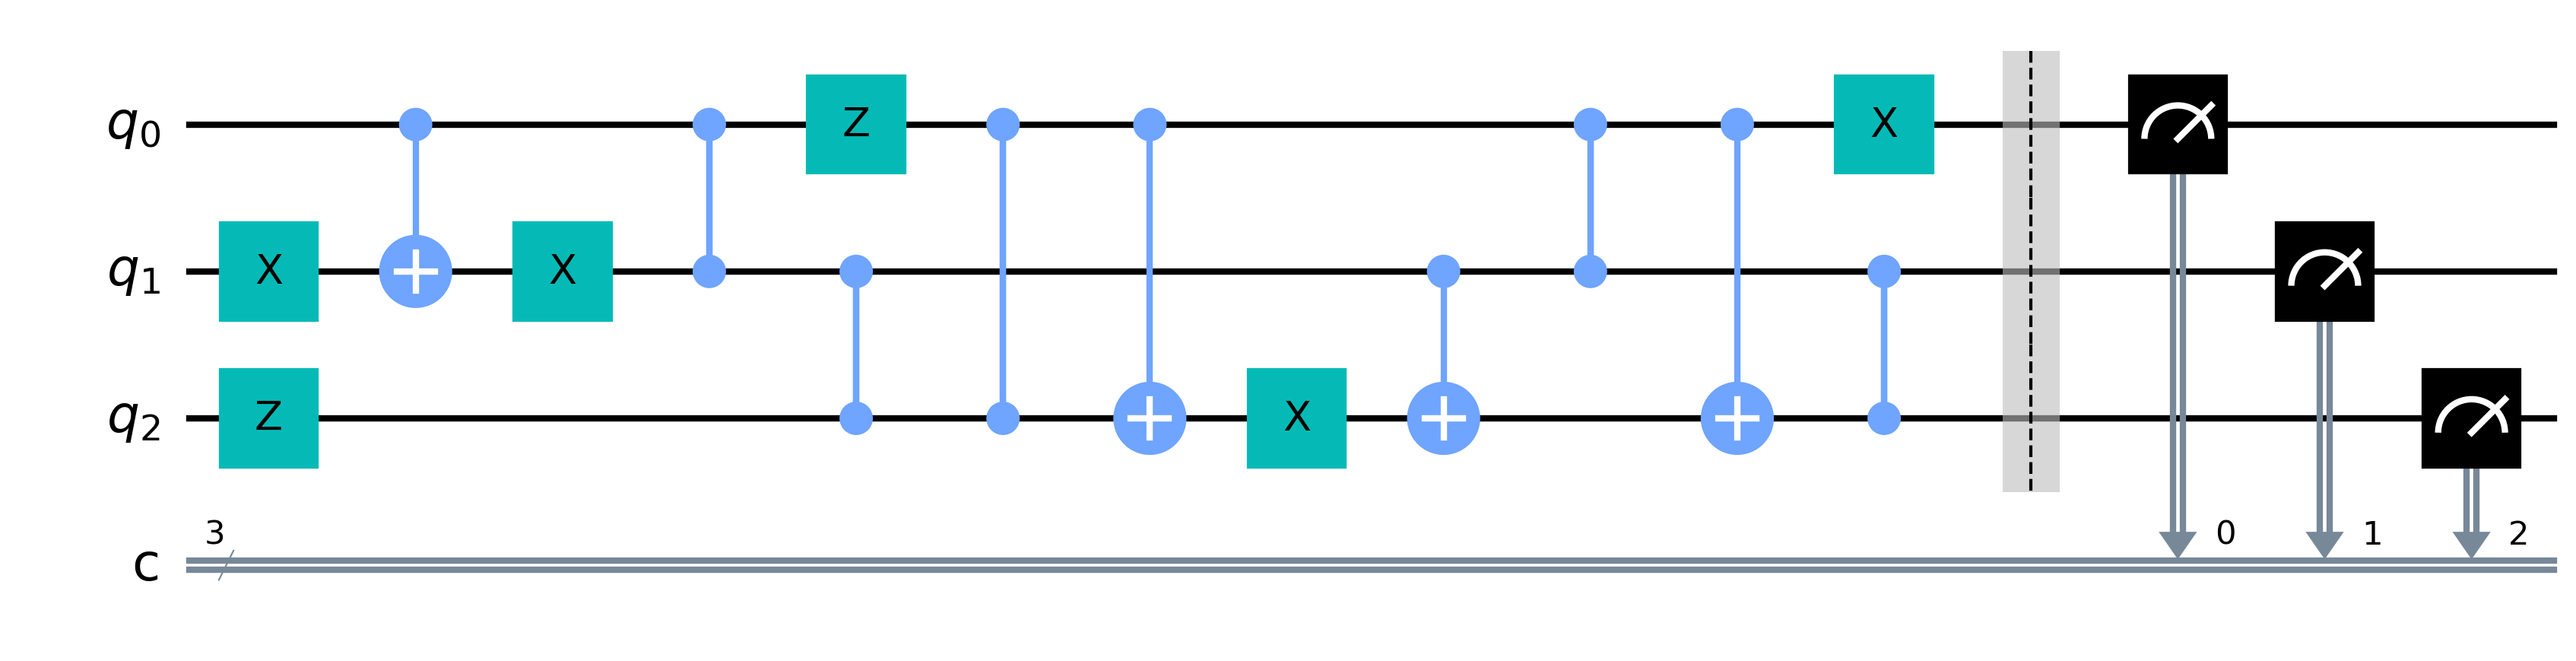

In [18]:
qc.draw('mpl', scale=3, filename='circuit.png')